In [2]:
%%capture
!git clone https://github.com/cw00dw0rd/ArangoNotebooks.git
!rsync -av ArangoNotebooks/ ./ --exclude=.git
!pip3 install pyarango
!pip3 install "python-arango>=5.0"
!pip3 install graphviz


Cloning into 'ArangoNotebooks'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 17 (delta 2), reused 17 (delta 2), pack-reused 0
Unpacking objects: 100% (17/17), done.
sending incremental file list
./
creds.dat
oasis.py
data/
data/ENCRYPTION
data/dump.json
data/imdb_edges.structure.json
data/imdb_edges_f4353381bd511b59d5cccbd7f7db840b.data.json.gz
data/imdb_vertices.structure.json
data/imdb_vertices_4ad17a956bfb063d03e22fb0da7d72cd.data.json.gz
tools/
tools/arangorestore

sent 19,430,585 bytes  received 210 bytes  38,861,590.00 bytes/sec
total size is 19,425,040  speedup is 1.00
     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 235kB 8.7MB/s 
     |████████████████████████████████| 81kB 2.2MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
  Created wheel for python-arango: filena

In [0]:
import json
import requests
import sys
import oasis
import time

from pyArango.connection import *
from arango import ArangoClient

In [4]:
# Retrieve tmp credentials from ArangoDB Tutorial Service
login = oasis.getTempCredentials("BestPracticesTutorial")

# Connect to the temp database
# Please note that we use the python-arango driver as it has better support for ArangoSearch 
database = oasis.connect_python_arango(login)

Requesting new temp credentials.
Temp database ready to use.


In [5]:
print("https://"+login["hostname"]+":"+str(login["port"]))
print("Username: " + login["username"])
print("Password: " + login["password"])
print("Database: " + login["dbName"])

https://5904e8d8a65f.arangodb.cloud:8529
Username: TUTbgqd85sq5rjho1r714k2a
Password: TUT652jr1rrhot09gwidm146pj
Database: TUTp10i416h5yehtyrpvbod7i


# IMDB Dataset

This notebook uses the IMDB dataset. It is loaded with detailed documents for actors, directors, and movies. The edges link the movies to the actors and movie genres.

You can access the ArangoDB WebUI and ArangoDB Graph Viewer to explore the data further at any time. Just click the link generated above, sign in with your temporary credentials, and you have access to a temporary but fully functional ArangoDB database.
![alt text](https://www.arangodb.com/wp-content/uploads/2020/01/image9.png)

In [16]:
!chmod 755 ./tools/arangorestore
!./tools/arangorestore -c none --server.endpoint http+ssl://{login["hostname"]}:{login["port"]} --server.username {login["username"]} --server.database {login["dbName"]} --server.password {login["password"]} --default-replication-factor 3  --input-directory "./data" 

2020-05-22T03:34:40Z [243] INFO [05c30] {restore} Connected to ArangoDB 'http+ssl://5904e8d8a65f.arangodb.cloud:8529'
2020-05-22T03:34:41Z [243] INFO [abeb4] {restore} Database name in source dump is 'TUT8056uus0lbousqpb64lwf'
2020-05-22T03:34:41Z [243] INFO [9b414] {restore} # Re-creating document collection 'imdb_vertices'...
2020-05-22T03:34:42Z [243] INFO [9b414] {restore} # Re-creating edge collection 'imdb_edges'...
2020-05-22T03:34:43Z [243] INFO [6d69f] {restore} # Dispatched 2 job(s), using 2 worker(s)
2020-05-22T03:34:43Z [243] INFO [d88c6] {restore} # Creating indexes for collection 'imdb_vertices'...
2020-05-22T03:34:43Z [243] INFO [d88c6] {restore} # Creating indexes for collection 'imdb_edges'...
2020-05-22T03:34:44Z [243] INFO [94913] {restore} # Loading data into edge collection 'imdb_edges', data size: 6463512 byte(s)
2020-05-22T03:34:45Z [243] INFO [94913] {restore} # Loading data into document collection 'imdb_vertices', data size: 4964324 byte(s)
2020-05-22T03:34:48

In [0]:
# TODO: Adjust import with Indexes and Graph already set and remove this code block

if database.has_graph('IMDB'):
    IMDB = database.graph('IMDB')
else:
    IMDB = database.create_graph('IMDB')

if not IMDB.has_edge_definition('imdb_edges'):
  IMDB.create_edge_definition(
      edge_collection='imdb_edges',
      from_vertex_collections=['imdb_vertices'],
      to_vertex_collections=['imdb_vertices']
     )
else:
  IMDB.replace_edge_definition(
      edge_collection='imdb_edges',
      from_vertex_collections=['imdb_vertices'],
      to_vertex_collections=['imdb_vertices']
     )

In [0]:
# We setup this up to display our graph results in the notebook.

from graphviz import Digraph
from IPython.display import Image

def visualize(result, size='10'):
  graph_name = 'imdb'

  g = Digraph(graph_name, filename=graph_name, format='jpeg', engine='neato')
  g.attr(overlap='false', size=size)
  g.attr('node', shape='circle', fixedsize='false', margin='0', color='blue',style='filled', fillcolor='#dbe2e2', fontname='arial')
  g.attr('edge', shape='arrow', color='gray')

  for item in result:
    for vertex in item['vertices']:
        g.node(vertex['_id'], label=vertex['label'])
    for edge in item['edges']:
        g.edge(edge['_from'], edge['_to'])
  return g


# Let's Get Started

---


This first example is a simple lookup of the movies that Will Smith has acted in. Take note that in this query we are taking advantage of many of our guidelines:


*   Capitlized keywords
*   Lowercase variables
*   Double space following a `FOR` statement
*   Multi-line comment style
*   Verbose variables

Continue reading to take a look at some important performance considerations taken with this query.


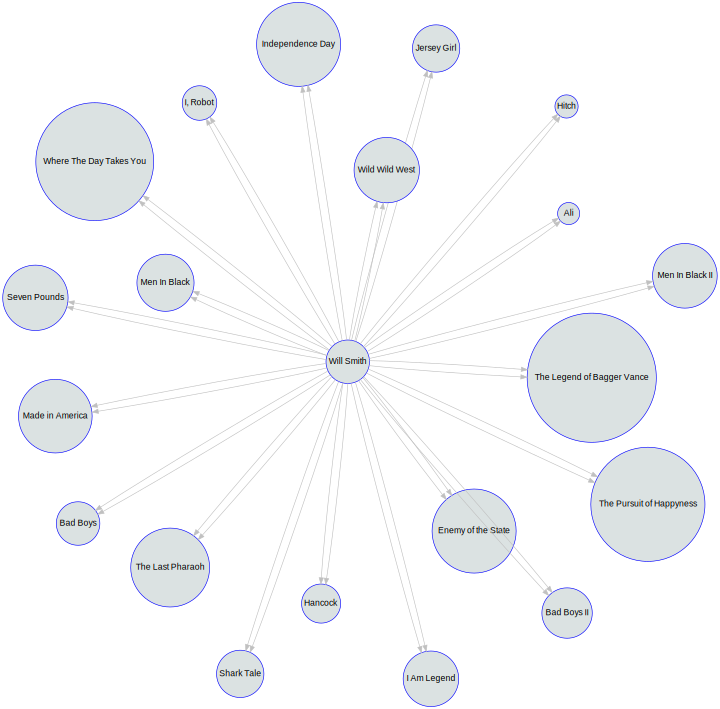

In [19]:
aql = database.aql

actorName = 'Will Smith'

# Execute the query
cursor = aql.execute(
  """
  WITH imdb_vertices
  FOR actor IN imdb_vertices 
    FILTER actor.name == @name
    FOR vertex, edge , path 
      IN 1..1 
      OUTBOUND actor /* The actor found from the first FOR loop */
      GRAPH 'IMDB'
      FILTER path.vertices[1].type == 'Movie' 
      RETURN path
  """,
  bind_vars={'name': actorName}
)

# Iterate through the result cursor
result = [doc for doc in cursor]

visualize(result)


# Indexes with Graph Traversals

The decision to `FILTER` on the path in this example, is an important consideration. In graph traversals, simply filtering on the vertex or edge variable does not utlize indexes.
<br />
<br />
The query goes from a vertex to an edge, then the edge indicates what the next connected vertex will be. The traversal continues in this way only finding out what the next vertex will be, once it reaches the next edge document. This is a natural process for a graph traversal, but it also means simply looking up all of the necessary documents from the index isn't possible, as it is not known what those documents will be until then. 
<br />
<br />
Instead of filtering on every document that comes along, you can instead wait until you have a full path, from your start vertex to your destination, and match your criteria against the path. This can significantly improve performance, since this process can utilize indexes. 
<br />
<br />
The following code block shows the AQL optomizer rule comparisons for the previous lookup, one query does the `FILTER` on the path and the other does the `FILTER` on the vertex.





In [20]:
import itertools

fast_profile = aql.explain(
  """
  WITH imdb_vertices
  FOR actor IN imdb_vertices 
    FILTER actor.name == 'Will Smith'
    FOR vertex, edge, path 
      IN 1..1 
      OUTBOUND actor /* The actor found from the first FOR loop */
      GRAPH 'IMDB'
      FILTER path.vertices[1].type == 'Movie' 
      RETURN path
  """
)

slow_profile = aql.explain(
  """
  WITH imdb_vertices
  FOR actor IN imdb_vertices 
    FILTER actor.name == 'Will Smith'
    FOR vertex, edge, path 
      IN 1..1 
      OUTBOUND actor /* The actor found from the first FOR loop */
      GRAPH 'IMDB'
      FILTER vertex.type == 'Movie' 
      RETURN path
  """
)

print("Filter on Path ".ljust(50, ' '), "Filter on Vertices")
print("--------------------------------------------------------------------------------")

for rule in itertools.zip_longest(fast_profile['rules'], slow_profile['rules']):
  if rule[0] is not None:
    p1 = (rule[0].ljust(40, ' '))
  else: 
    p1 = None
  if rule[1] is not None:
    p2 = (rule[1].ljust(40, ' '))
  else:
    p2 = None
  
  print(p1,"|".ljust(10, ' '), p2)


Filter on Path                                     Filter on Vertices
--------------------------------------------------------------------------------
use-indexes                              |          use-indexes                             
remove-filter-covered-by-index           |          remove-filter-covered-by-index          
optimize-traversals                      |          optimize-traversals                     
remove-filter-covered-by-traversal       |          remove-unnecessary-calculations-2       
remove-unnecessary-calculations-2        |          cluster-one-shard                       
cluster-one-shard                        |          None


  Looking at the optimizer rules applied for each traversal shows us
  two important rules that can be applied.

  In the example that filters on the path, the optimizer is able to:
  - `remove-filter-covered-by-traversal`
  - `remove-unnecessary-calculations-2` 

  These rules indicate that because we are filtering on the path, our `FILTER`
  was indeed covered by our traversal. This also results in no longer needing to
  perform calculations on these documents, which is an expensive operation.

  With larger graph queries, taking advantage of these optimizations results 
  in noticeable performance improvements.
<br />

#  That's Nice But..  

You might be thinking, that's nice but how can I actually make use of this in my queries? That is a fair question and we will continue exploring indexes as well as building graph queries that utilize optimization rules and concepts.

To highlight what this means, the following sections will cover these topics:
*   Index Utilization
*   Choosing a start vertex
*   `PRUNE` vs `FILTER`

We have already started the conversation on indexes in graph traversals and it will be a topic important for every query. The goal of the following example is to find all the movies directed by James Cameron and then list the associated actors for those movies. This example is a bit more complex as we start nesting `FOR` loops. This example hopefully starts to show the benefits of some of the formatting guidelines such as, whitespace and capitalization. 



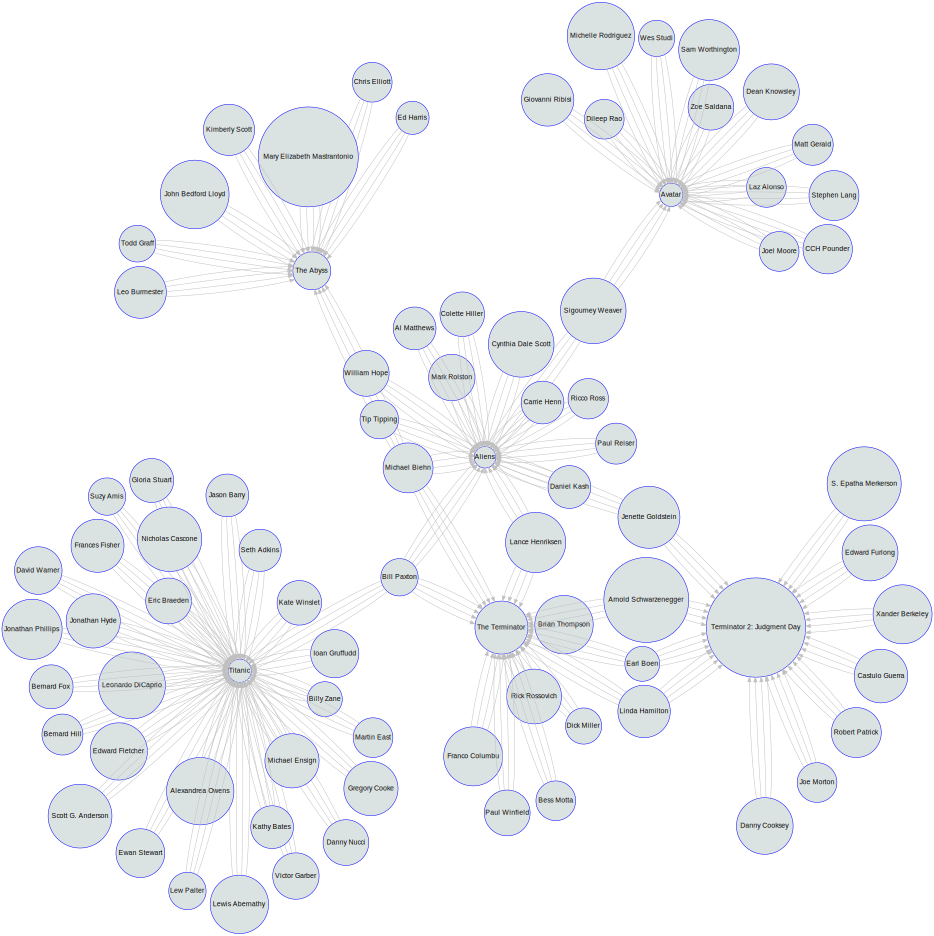

In [25]:
directorName = "James Cameron"

results = aql.execute(
    """
WITH imdb_vertices
FOR director IN imdb_vertices
  FILTER director.name == @name
  LIMIT 1
  FOR movie, edge, path 
    IN 1..1
    OUTBOUND director
    GRAPH "IMDB"
    FILTER path.edges[*].`$label` ALL == 'DIRECTED'
    FOR vertex2, edge2, path2
      IN 1..1
      INBOUND movie
      GRAPH "IMDB"
      FILTER path2.edges[*].`$label` ALL == 'ACTS_IN'
      RETURN path2
      """,
      bind_vars= {'name': directorName}
)
visualize(results, size='13')

## Start Vertex
In AQL it is required that you choose a start vertex as a place where your traversal will actually start. The choice of your start vertex can have a big impact on the performance of your queries. 

The rule for your start vertex is that **specificity is king**. 
There are a number of ways I could have attempted to achieve similar results for this query. The query could have instead started with an actor (perhaps the least specific option) or a movie but instead, it starts with the director. This is of course logical, considering we are only wanting the actors and movies that this director was involved with. It is also a good idea to start with the actual director as this allows us to search on the edges for the `DIRECTED` label, which can be covered by an index with `_from` and `$label`. 

Some questions to ask before a query like this are:
*   What exactly is the intended result of the query?
*   How is our data modeled?
*   What is the specificity of our start vertex?

This dataset doesn’t contain any ‘super nodes’, nodes with a very large number of inbound and outbound edges, but that is something to keep in mind. 

***You never want to use a super node as a start vertex.***

If you start at a vertex that has a very high number of connecting edges, your traversal will need to travel down each path and this can result in long running queries. Try to start at the most relevant place possible, such as a single director, and then filter down from there.

## Matching Documents
For this example we start with Keanu Reeves and then look at the movies he has acted in and then the movies his co-stars have acted, all with the action genre type. If you are going to watch action movies, you might as well watch Keanu Reeves or at least the friends of Keanu Reeves.


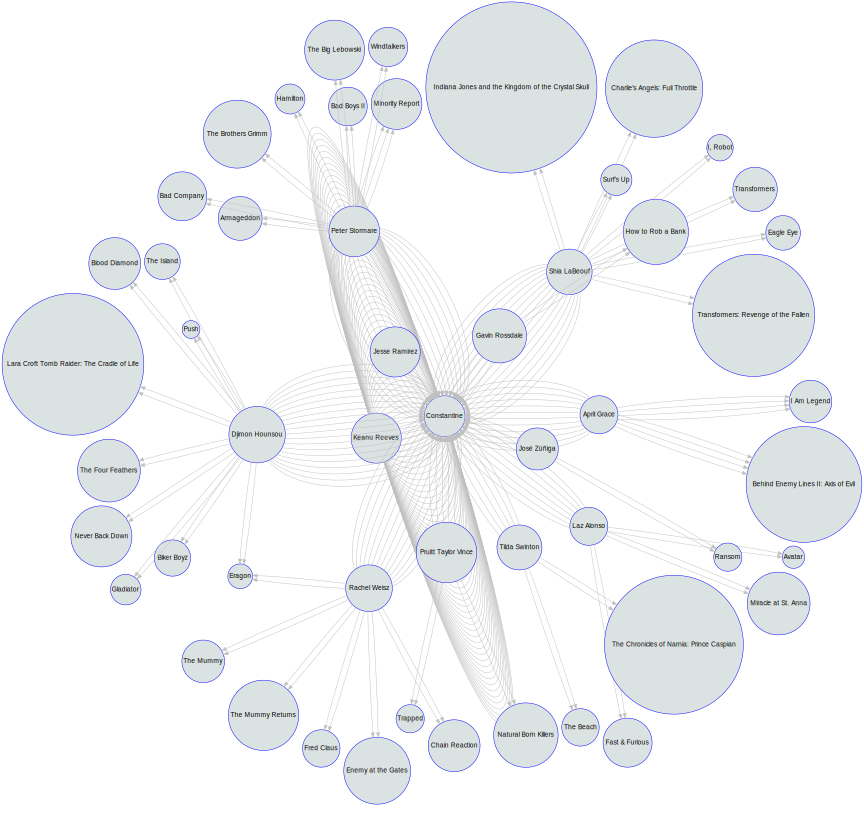

In [26]:
cursor = aql.execute(
    """
    WITH imdb_vertices
    FOR actor IN imdb_vertices
      FILTER actor.name == 'Keanu Reeves'
      FOR v,e,p
        IN 1..3
        ANY actor
        GRAPH "IMDB"
        PRUNE p.vertices[*].genre ALL == "Action"
        FILTER v.genre == "Action"
        FILTER p.vertices[*]._key ALL != "action"
        LIMIT 100
        RETURN p 
    """
)

visualize(cursor, size='12')

Two common ways of matching documents in a graph traversal are:
*   [PRUNE](https://www.arangodb.com/docs/stable/aql/graphs-traversals.html#pruning)
*   [FILTER](https://www.arangodb.com/docs/stable/aql/operations-filter.html)

It is easy to think that perhaps `PRUNE` might be used in place of `FILTER` or vice-versa. However, rather than making a decision on which one to use, these two keywords instead make a powerful team. In the example below we use `PRUNE` as a way to quickly stop traversing along a path if that path doesn’t contain all genre types of ‘Action’. 

This `PRUNE` is combined with a vertex that makes sure the final vertex is also of genre type ‘Action’. The final `FILTER` is due to the fact that this dataset contains a genre document that can potentially link unrelated films and actors. 


This query let us find very specific and fine tuned results. However, it is this sort of search criteria that can make following a specific guideline or rule for query performance difficult. These examples along with the formatting guidelines can serve as a base for improving the way you think about formatting your graph queries and your overall query performance. 